# Imports & TF setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split

/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

Using TensorFlow backend.


Amount of GPUs available: 4


# Read data

In [3]:
dir = '//datc//opschaler//combined_gas_smart_weather_dfs//processed//'
dwelling_id = 'P01S01W8655'
df = pd.read_csv(dir+dwelling_id+'_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])

# Prepare data for ML

In [4]:
# Resmaple data to 1 day, this gave decent results with linear regression
df = df.resample('1D').mean()

# Check for NaNs
df.isnull().sum()

eMeter             0
eMeterReturn       3
eMeterLow          3
eMeterLowReturn    3
ePower             3
ePowerReturn       3
gasMeter           0
gasPower           3
DD                 0
DR                 0
FF                 0
FX                 0
N                  0
P                  0
Q                  0
RG                 0
SQ                 0
T                  0
T10                0
TD                 0
U                  0
VV                 0
WW                 0
dtype: int64

In [5]:
# Drop NaNs
df = df.dropna()
df.isnull().sum()

eMeter             0
eMeterReturn       0
eMeterLow          0
eMeterLowReturn    0
ePower             0
ePowerReturn       0
gasMeter           0
gasPower           0
DD                 0
DR                 0
FF                 0
FX                 0
N                  0
P                  0
Q                  0
RG                 0
SQ                 0
T                  0
T10                0
TD                 0
U                  0
VV                 0
WW                 0
dtype: int64

In [8]:
# Select the relevant variables
data = df[['gasPower', 'Q', 'T']]

## Check the selected data

In [9]:
def create_corr_matrix(df, dwelling_id, annot):
    """
    Pearson correlation coefficient matrix. 
    The Pearson correlation coefficient is a measure of the linear correlation between two variables.
    """
    plt.clf()
    
    corr = df.corr()
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True

    if annot:
        fig, ax = plt.subplots(figsize=(5,5))
    else:
        fig, ax = plt.subplots()

    fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=annot, ax=ax, 
                cbar_kws={'label':'Pearson correlation coefficient [-]'})

    fig.set_title('Correlation matrix of dwelling ID: '+dwelling_id)
    fig.tick_params(axis='x', rotation=90)
    fig.tick_params(axis='y', rotation=0)

    fig = fig.get_figure()
    fig.tight_layout()
    fig.show()
    
    print('Saving heatmap')
    #fig.savefig('//datc//opschaler//EDA//Pearson_corr//' + dwelling_id + '.png', dpi=300)
    return fig

Saving heatmap


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 576x396 with 0 Axes>

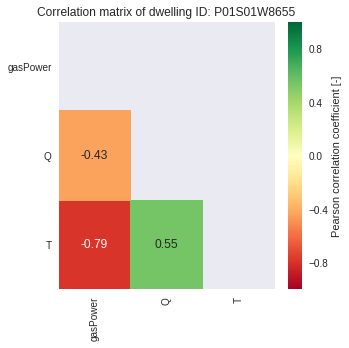

In [10]:
sns.set() # Set sns style
fig = create_corr_matrix(data, dwelling_id, True)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1.23,'1 Day mean of dwelling: P01S01W8655')

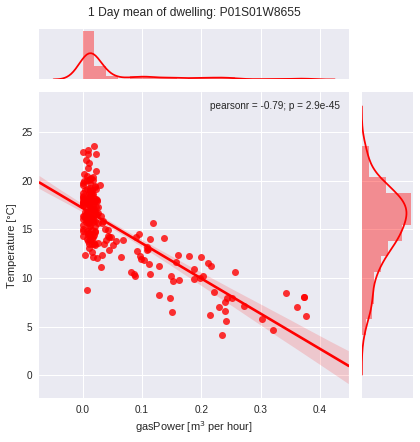

In [11]:
fig = sns.jointplot(x="gasPower", y="T", data=data, kind="reg", color='r')
sns.plt.xlabel('gasPower [m$^3$ per hour]')
sns.plt.ylabel('Temperature [°C]')
sns.plt.tight_layout()
sns.plt.title('1 Day mean of dwelling: %s' % dwelling_id, y=1.23)

/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1.23,'1 Day mean of dwelling: P01S01W8655')

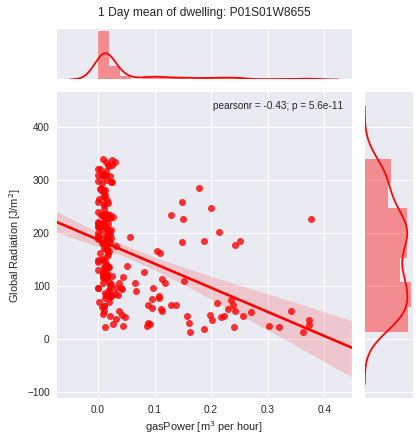

In [12]:
fig = sns.jointplot(x="gasPower", y="Q", data=data, kind="reg", color='r')
sns.plt.xlabel('gasPower [m$^3$ per hour]')
sns.plt.ylabel('Global Radiation [J/m$^2$]')
sns.plt.tight_layout()
sns.plt.title('1 Day mean of dwelling: %s' % dwelling_id, y=1.23)

## Preprocessing data